In [19]:
from dotenv import load_dotenv
import os
import sys
from pathlib import Path
from aves.config import setup_style

load_dotenv()
setup_style()

AVES_ROOT = Path("data")
EOD_PATH = AVES_ROOT / "external" / "EOD_STGO"
CENSUS_GEO_ROOT = AVES_ROOT / "external" / "censo_2017" / "geometria"

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
from aves.data import eod, census
import matplotlib as mpl

In [21]:
viajes = eod.read_trips(EOD_PATH)

# descartamos sectores que no sean relevantes en los orígenes y destinos de los viajes
viajes = viajes[
    (viajes["SectorOrigen"] != "Exterior a RM")
    & (viajes["SectorDestino"] != "Exterior a RM")
    & (viajes["SectorOrigen"] != "Extensión Sur-Poniente")
    & (viajes["SectorDestino"] != "Extensión Sur-Poniente")
    & pd.notnull(viajes["SectorOrigen"])
    & pd.notnull(viajes["SectorDestino"])
]

print(len(viajes))

83439


In [22]:
personas = eod.read_people(EOD_PATH)
hogares = eod.read_homes(EOD_PATH)
tabla = viajes.merge(personas).merge(hogares.drop('TipoDia', axis=1))

In [23]:
tabla["Peso"] = (
    tabla["FactorExpansion"] * tabla["FactorPersona"]
)

In [24]:
zones = gpd.read_file(AVES_ROOT / 'processed' / 'scl_zonas_urbanas.json').set_index('ID')
zones.head()

,AREA,Zona,Com,Comuna,REGION,NOM_REGION,PROVINCIA,NOM_PROVIN,COMUNA,NOM_COMUNA,URBANO,TIPO,NOM_CATEG,SHAPE_Leng,SHAPE_Area,area_m2,geometry
ID,,,,,,,,,,,,,,,,,
103,837.7500,103.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13105,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,4.575649e+05,"POLYGON ((-70.65492 -33.55500, -70.65517 -33.5..."
104,998.8125,104.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13105,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,7.725462e+05,"POLYGON ((-70.67599 -33.55542, -70.67452 -33.5..."
106,286.2500,106.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13105,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,2.693838e+06,"POLYGON ((-70.67891 -33.55911, -70.68019 -33.5..."
115,857.4375,115.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13105,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,7.534193e+05,"POLYGON ((-70.67625 -33.55513, -70.67653 -33.5..."
116,853.9375,116.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13105,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,7.184305e+05,"POLYGON ((-70.66564 -33.55260, -70.66309 -33.5..."


In [25]:
from aves.data.census.loading import read_census_map
comunas = read_census_map('comuna', path=CENSUS_GEO_ROOT / "R13")

<Axes: >

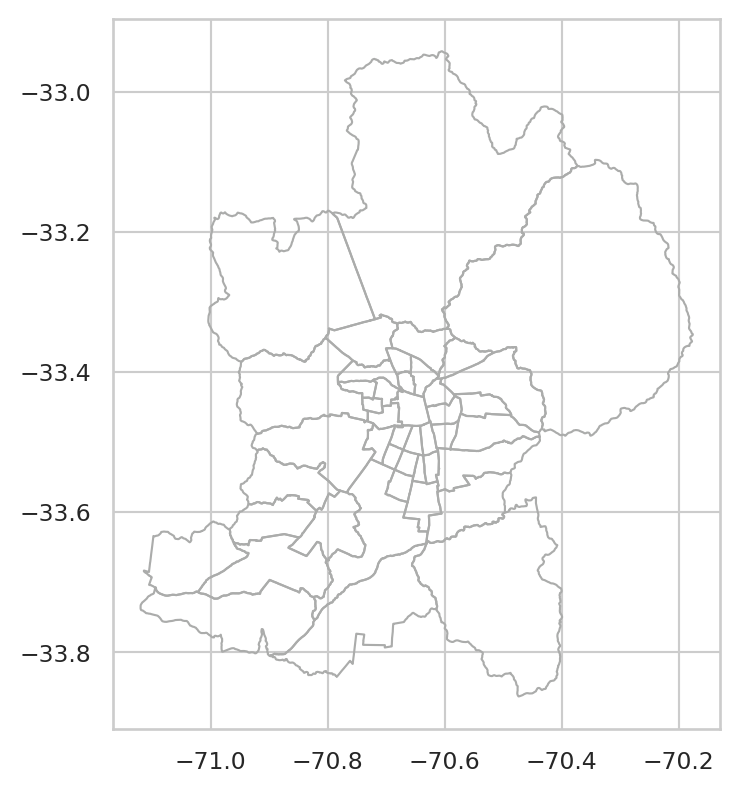

In [26]:
comunas_urbanas = comunas[comunas['COMUNA'].isin(zones['Com'].unique())].drop('NOM_COMUNA', axis=1).copy()
comunas_urbanas['NombreComuna'] = comunas_urbanas['COMUNA'].map(dict(zip(zones['Com'], zones['Comuna'])))
comunas_urbanas.plot(facecolor="none", edgecolor="#abacab")

/mnt/c/Users/nacho/OneDrive/Escritorio/Visualización/Visual_ave/aves/src/aves/features/geo.py:27: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ).pipe(lambda x: x[x.geometry.area > 0])


<Axes: >

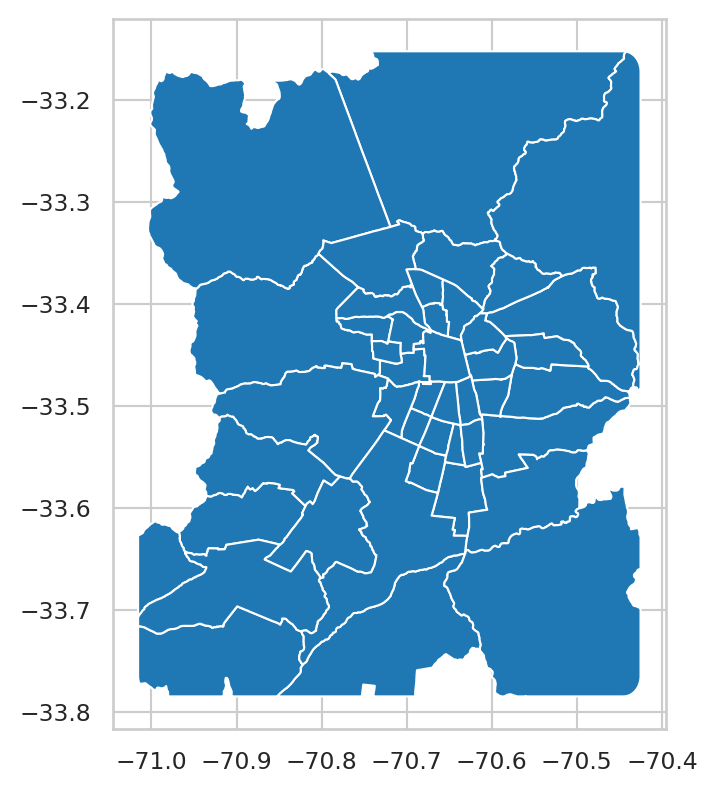

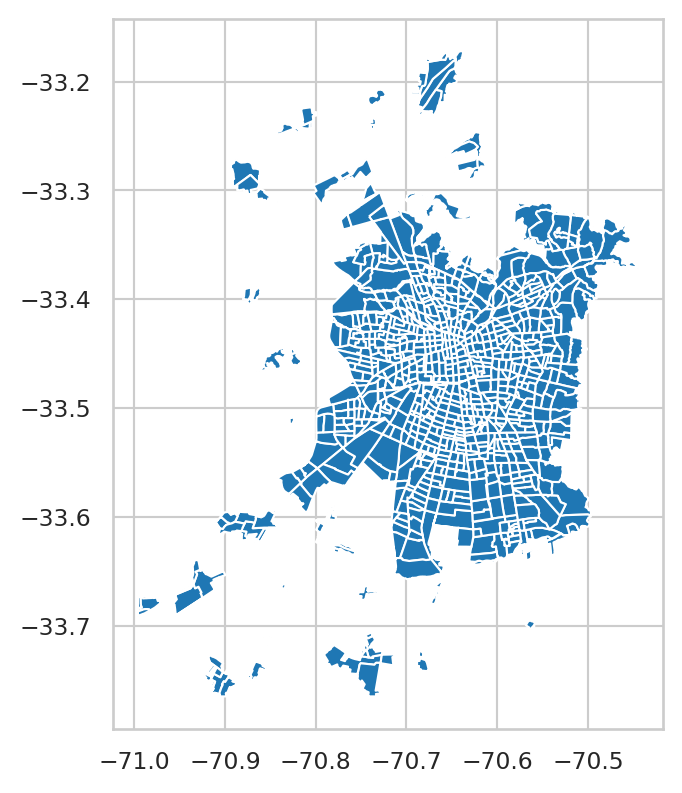

In [27]:
from aves.features.geo import clip_area_geodataframe

bounding_box = zones.total_bounds
comunas_urbanas = clip_area_geodataframe(comunas_urbanas, zones.total_bounds, buffer=0.02)
comunas_urbanas.plot()
zones.plot()

In [28]:
from aves.features.utils import normalize_rows

matrix = (
    tabla[
        (tabla["Proposito"] != "volver a casa")
        & (tabla["ComunaOrigen"].isin(comunas_urbanas["NombreComuna"]))
        & (tabla["ComunaDestino"].isin(comunas_urbanas["NombreComuna"]))
        & (tabla["ComunaOrigen"] != tabla["ComunaDestino"])
    ]
    .groupby(["Proposito", "ComunaOrigen", "ComunaDestino", "ZonaOrigen", "ZonaDestino"])
    .agg(n_viajes=("Peso", "sum"))
    .sort_values("n_viajes", ascending=False)
    #.assign(cumsum_viajes=lambda x: x["n_viajes"].cumsum() / x["n_viajes"].sum())
    #.pipe(lambda x: x[x["cumsum_viajes"] <= 0.75])
    .reset_index()
)

matrix

,Proposito,ComunaOrigen,ComunaDestino,ZonaOrigen,ZonaDestino,n_viajes
0,Recreación,Lo Prado,La Florida,358,219,12653.237089
1,Buscar o Dejar a alguien,Ñuñoa,Providencia,429,494,5976.740485
2,Trámites,Cerro Navia,Providencia,76,501,5776.975642
3,De compras,Pedro Aguirre Cerda,San Miguel,460,646,5236.584621
4,Al trabajo,San Ramón,La Cisterna,655,172,4960.198328
...,...,...,...,...,...,...
21925,Trámites,Colina,Santiago,729,18,0.876170
21926,Recreación,Colina,Santiago,729,19,0.873260
21927,De compras,Colina,Santiago,729,19,0.873260
21928,Al trabajo,Calera de Tango,San Bernardo,798,766,0.652380


In [29]:
matrix['n_viajes'].sum()

3797749.329267904

In [30]:
fixed_zones = zones.reset_index().dissolve(by='ID').reset_index()

In [31]:
from aves.models.network import Network

network = Network.from_edgelist(
    matrix[
        (matrix["Proposito"] == "Al estudio")
        & (matrix["ZonaOrigen"] != matrix["ZonaDestino"])
        & (matrix["ZonaOrigen"].isin(fixed_zones["ID"]))
        & (matrix["ZonaDestino"].isin(fixed_zones["ID"]))
    ].pipe(
        lambda x: x.sort_values("n_viajes", ascending=False)
        .assign(cumsum_viajes=lambda x: x["n_viajes"].cumsum() / x["n_viajes"].sum())
        .pipe(lambda x: x[x["n_viajes"] >= x['n_viajes'].quantile(0.975)])
    ),
    source="ZonaOrigen",
    target="ZonaDestino",
    weight="n_viajes",
)
network

In [32]:
from aves.visualization.networks import NodeLink

nodelink = NodeLink(network)
nodelink.layout_nodes(method="geographical", geodataframe=fixed_zones, node_column="ID")

/mnt/c/Users/nacho/OneDrive/Escritorio/Visualización/Visual_ave/aves/src/aves/models/network/layouts.py:426: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  node_positions = positions_to_array(self.geodf.geometry.centroid)


In [33]:
nodelink.set_node_drawing("plain")


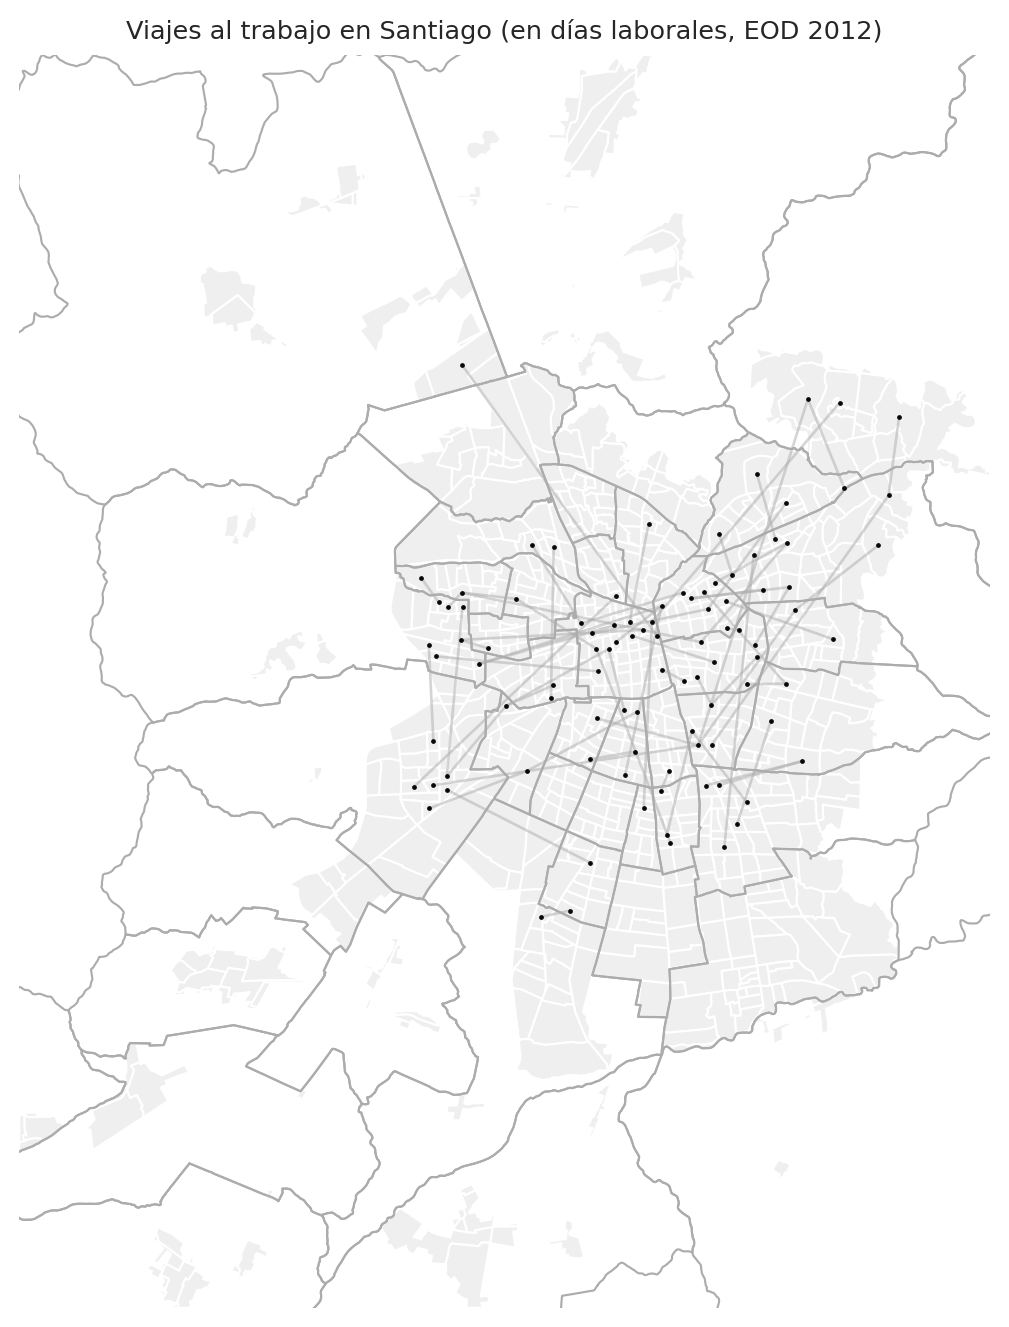

In [34]:
from aves.visualization.figures import figure_from_geodataframe

fig, ax = figure_from_geodataframe(zones, height=7)

# contexto
zones.plot(ax=ax, facecolor='#efefef', edgecolor='white', zorder=0)
comunas_urbanas.plot(ax=ax, facecolor='none', edgecolor='#abacab', zorder=1)

nodelink.plot(ax, nodes=dict(palette='PuRd', edgecolor='black', node_size=1, alpha=0.95), edges=dict(alpha=0.5), zorder=2)

ax.set_title('Viajes al trabajo en Santiago (en días laborales, EOD 2012)')

fig.tight_layout()

In [35]:
from aves.features.geo import to_point_geodataframe

origenes_viajes = to_point_geodataframe(
    tabla, "OrigenCoordX", "OrigenCoordY", crs="epsg:32719"
).to_crs(zones.crs)

destinos_viajes = to_point_geodataframe(
    tabla, "DestinoCoordX", "DestinoCoordY", crs="epsg:32719"
).to_crs(zones.crs)

In [36]:
from aves.models.grid import H3Grid

hex_grid = H3Grid.from_geodf(zones, grid_level=7, extra_margin=0.025)
hex_grid.geodf

,h3_cell_id,geometry
0,611130916462395391,"POLYGON ((-70.99735 -33.52388, -71.00559 -33.5..."
1,611130601923149823,"POLYGON ((-70.86276 -33.71039, -70.87099 -33.7..."
2,611130918895091711,"POLYGON ((-70.87012 -33.33289, -70.87834 -33.3..."
3,611130914029699071,"POLYGON ((-70.88730 -33.51230, -70.89552 -33.5..."
4,611130903896260607,"POLYGON ((-70.54082 -33.29767, -70.54901 -33.3..."
...,...,...
826,611130898712100863,"POLYGON ((-70.53691 -33.48655, -70.54510 -33.4..."
827,611130926679719935,"POLYGON ((-70.55193 -33.64554, -70.56013 -33.6..."
828,611130837911470079,"POLYGON ((-71.00093 -33.33478, -71.00916 -33.3..."
829,611130914113585151,"POLYGON ((-70.92901 -33.49305, -70.93724 -33.5..."


In [37]:
activities = {'Al estudio': 'Recurrentes',
 'Al trabajo': 'Recurrentes',
 'Por trabajo': 'Recurrentes',
 'Por estudio': 'Recurrentes',
 'volver a casa': 'N/A',
 'De compras': 'Mantención',
 'Trámites': 'Mantención',
 'De salud': 'Salud',
 'Buscar o Dejar a alguien': 'Discrecional',
 'Visitar a alguien': 'Discrecional',
 'Recreación': 'Discrecional',
 'Otra actividad (especifique)': 'Discrecional',
 'Comer o Tomar algo': 'Discrecional',
 'Buscar o dejar algo': 'Discrecional'}

activities


{'Al estudio': 'Recurrentes',
 'Al trabajo': 'Recurrentes',
 'Por trabajo': 'Recurrentes',
 'Por estudio': 'Recurrentes',
 'volver a casa': 'N/A',
 'De compras': 'Mantención',
 'Trámites': 'Mantención',
 'De salud': 'Salud',
 'Buscar o Dejar a alguien': 'Discrecional',
 'Visitar a alguien': 'Discrecional',
 'Recreación': 'Discrecional',
 'Otra actividad (especifique)': 'Discrecional',
 'Comer o Tomar algo': 'Discrecional',
 'Buscar o dejar algo': 'Discrecional'}

In [38]:
grid_destinos = (
    gpd.sjoin(destinos_viajes, hex_grid.geodf, predicate="within")
    .pipe(lambda x: x[x["Proposito"].isin(activities.keys())])
    .assign(actividad=lambda x: x["Proposito"].map(activities))
)

In [39]:
from aves.features.utils import logodds_ratio_with_uninformative_dirichlet_prior

grid_actividades = (
    grid_destinos.groupby(["actividad", "h3_cell_id"])["Peso"]
    .sum()
    .unstack()
    .T.fillna(0)
    .pipe(logodds_ratio_with_uninformative_dirichlet_prior)
)

grid_actividades

actividad,Discrecional,Mantención,N/A,Recurrentes,Salud
611130838179905535,-12.914243,-0.150645,22.825596,-0.335612,-0.131870
611130838196682751,-17.125685,-12.752507,36.417476,-11.615398,-0.154977
611130838263791615,-20.146925,-19.056686,36.971786,-13.311173,6.649003
611130898712100863,-11.658238,-16.285083,27.962410,-7.635250,-0.138275
611130898745655295,-56.651679,-27.379143,115.619438,-60.825078,-22.170884
...,...,...,...,...,...
611130952164311039,-0.130017,-0.128951,-0.147554,0.290088,-0.110175
611130952181088255,-0.079573,-0.078507,-0.097109,0.189180,-0.059732
611130952197865471,-0.110183,-0.109116,0.234036,-0.119529,-0.090341
611130952214642687,-0.124563,-0.123497,-0.142100,0.279179,-0.104721


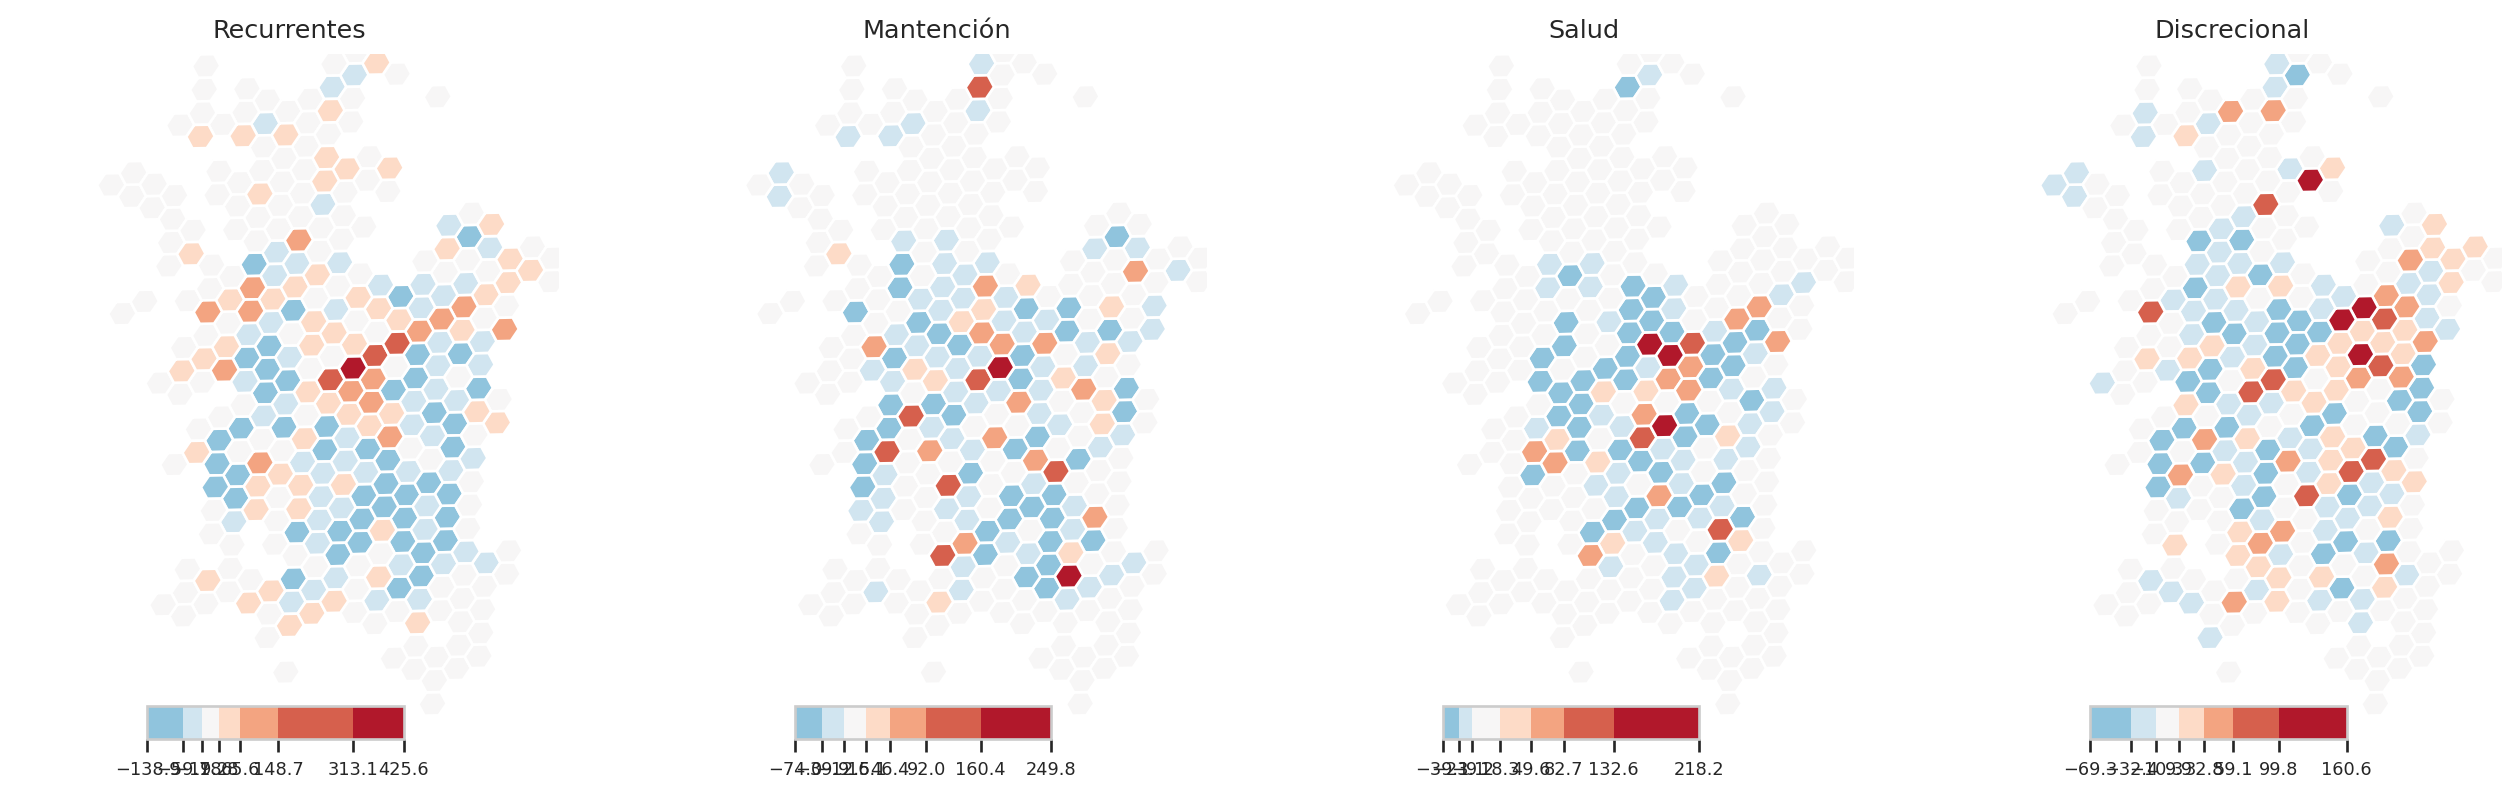

In [40]:
from aves.visualization.figures import small_multiples_from_geodataframe
from aves.visualization.maps import choropleth_map

fig, axes = small_multiples_from_geodataframe(zones, 4)

activity_order = ['Recurrentes', 'Mantención', 'Salud', 'Discrecional']

for ax, col in zip(axes, activity_order):
    choropleth_map(ax, hex_grid.geodf.join(grid_actividades, on='h3_cell_id'),col, k=7, binning='fisher_jenks')
    ax.set_title(col)

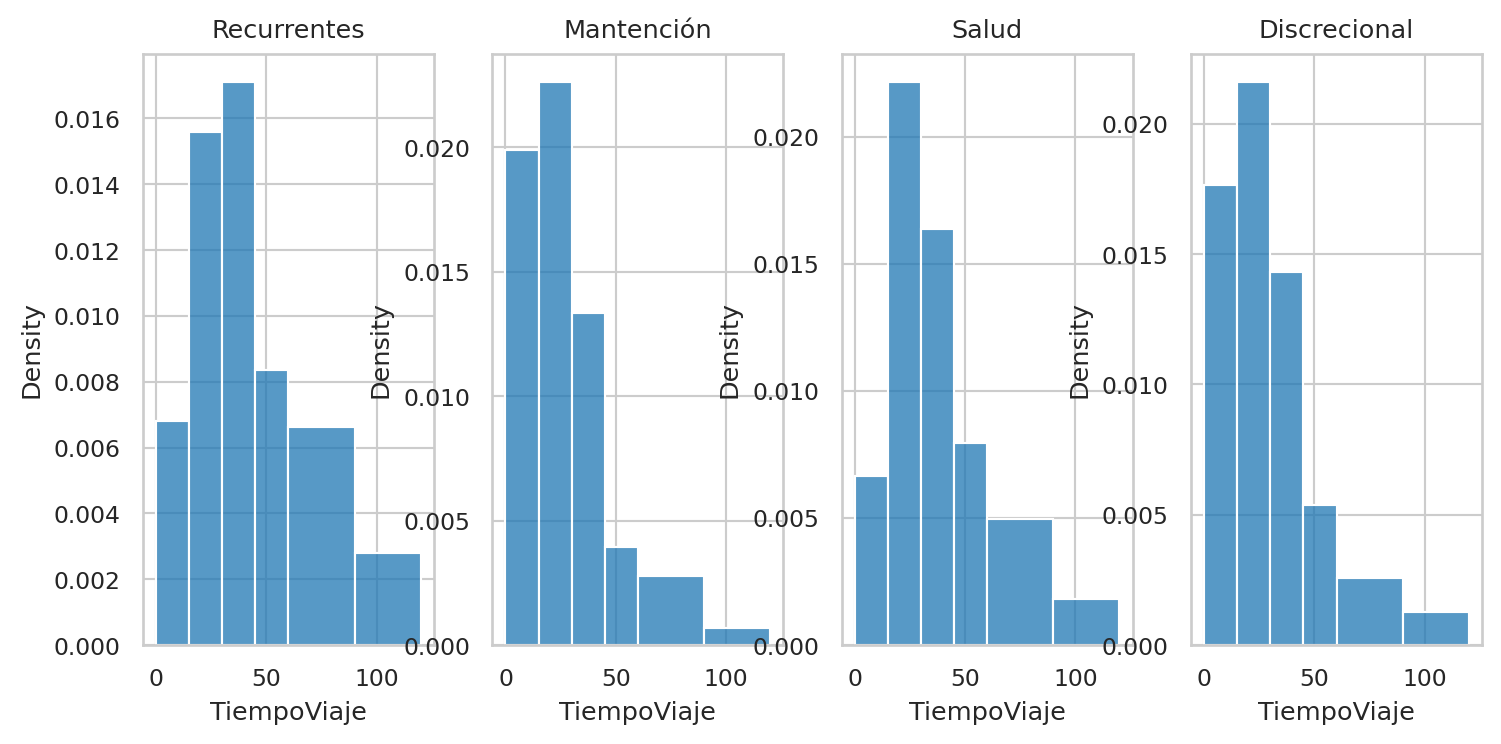

In [41]:
fig, axes = plt.subplots(1, 4, figsize=(9, 4))

for ax, col in zip(axes, activity_order):
        sns.histplot(data=grid_destinos[grid_destinos['actividad'] == col], x='TiempoViaje', weights='Peso', stat='density', bins=[0, 15, 30, 45, 60, 90, 120], ax=ax)
        ax.set_title(col)


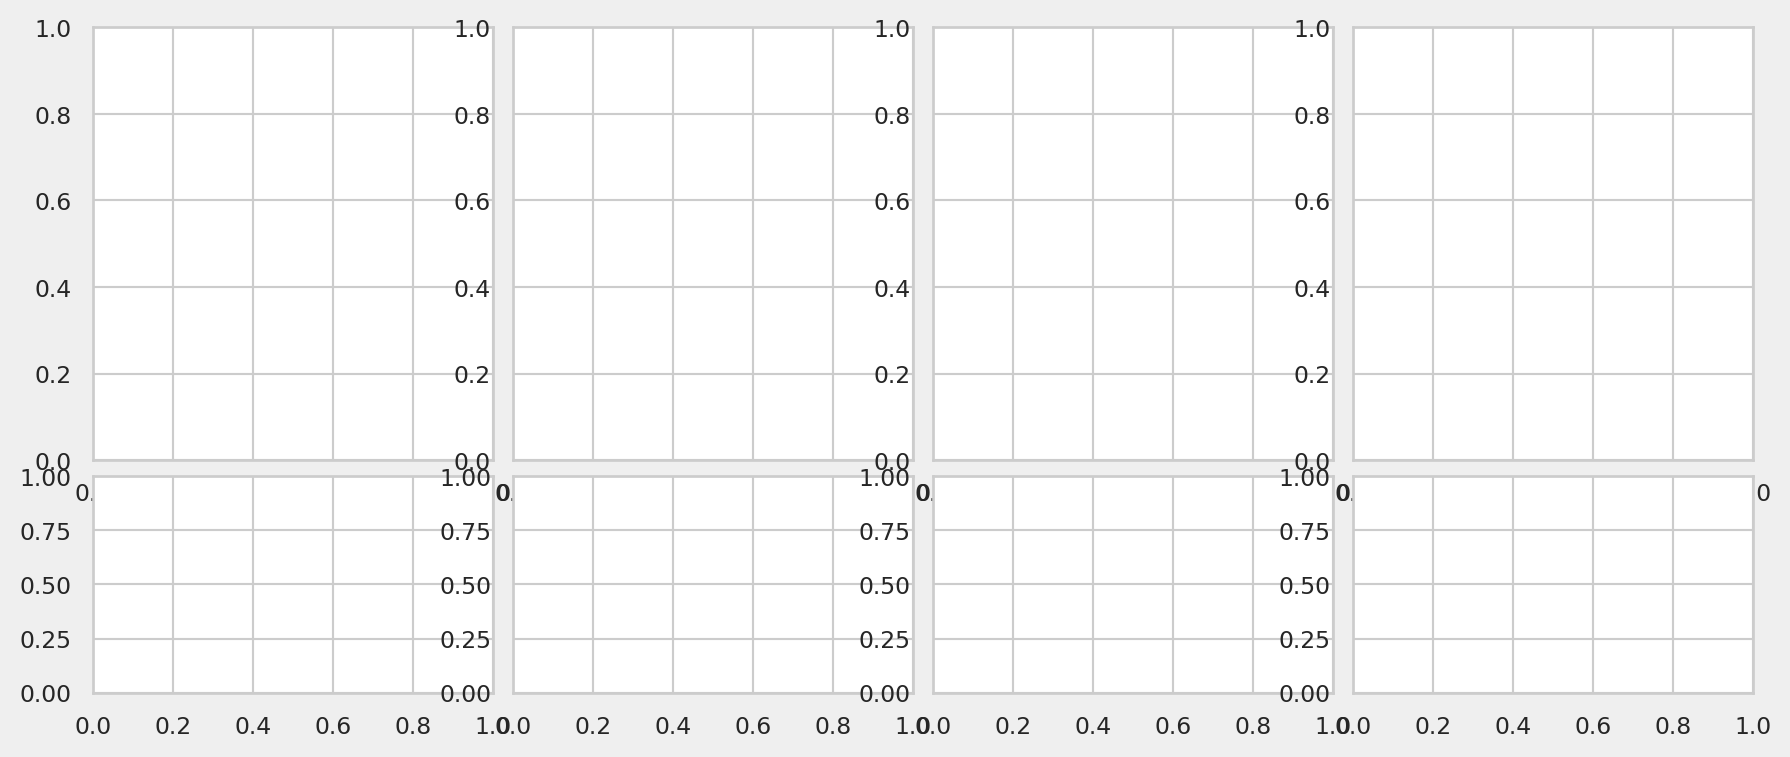

In [42]:
import matplotlib.gridspec as gridspec

h_space = 0.1
w_space = 0.05

bounding_box = zones.total_bounds
map_aspect_ratio = (bounding_box[2] - bounding_box[0]) / (bounding_box[3] - bounding_box[1])

height_ratios = [1.0, 0.5]

y_size = sum(height_ratios) * 3
x_size = map_aspect_ratio * len(activity_order) * 3


fig = plt.figure(figsize=(x_size, y_size))
fig.set_facecolor('#efefef')

gs = gridspec.GridSpec(
    len(height_ratios),
    len(activity_order),
    figure=fig,
    hspace=0.05,
    wspace=0.05,
    height_ratios=height_ratios,
)

for i, col in enumerate(activity_order):
    fig.add_subplot(gs[0,i])
    fig.add_subplot(gs[1,i])




/tmp/ipykernel_8769/2120346083.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


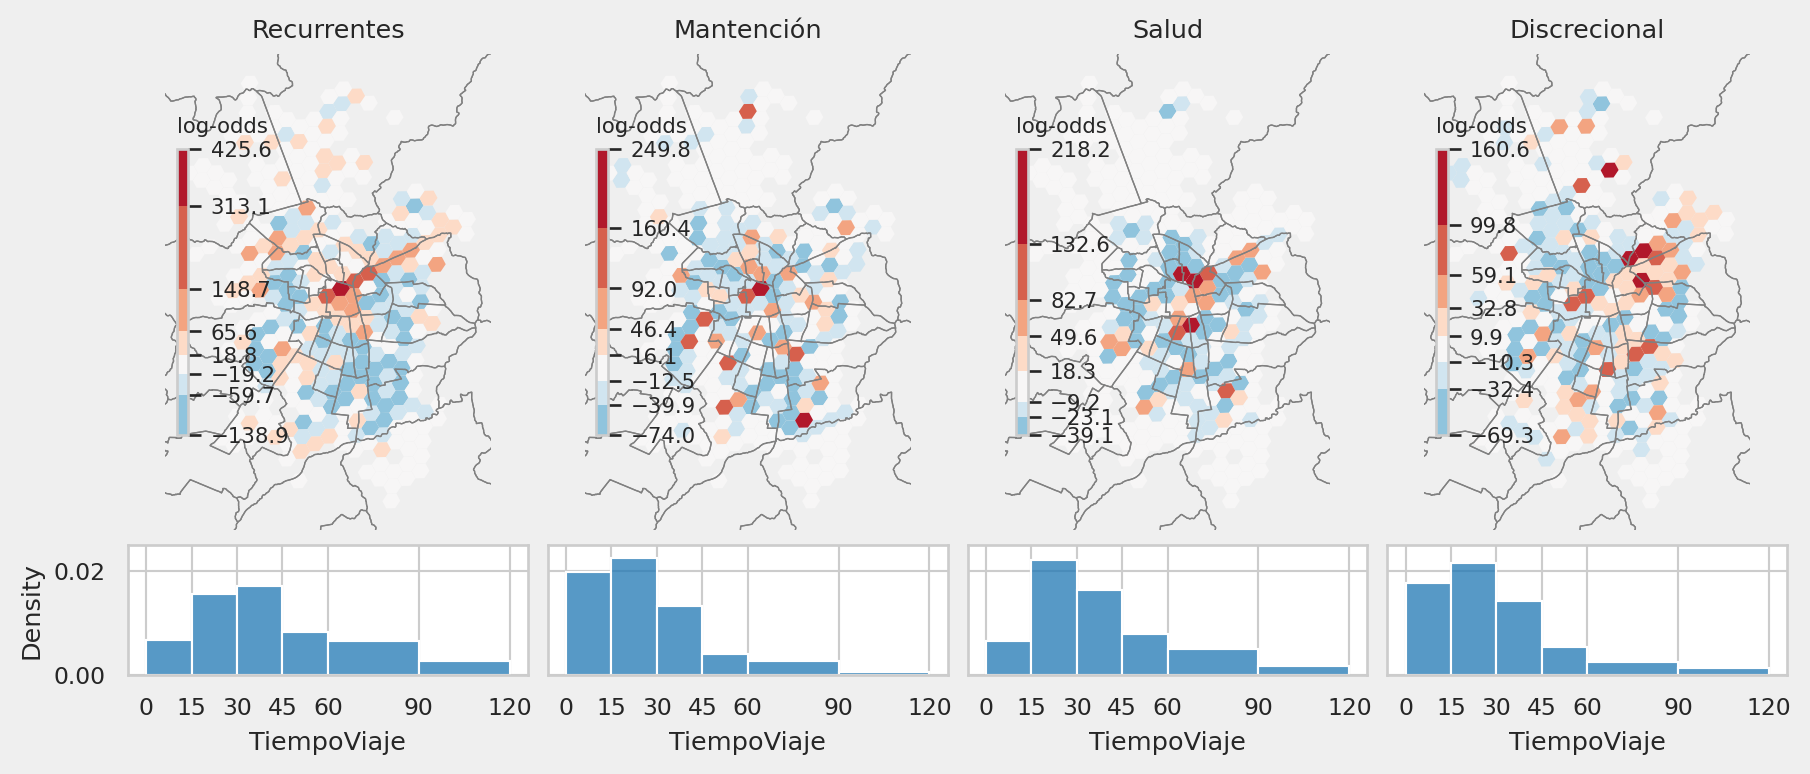

In [43]:
height_ratios = [1.1, 0.3]

y_size = sum(height_ratios) * 3
x_size = map_aspect_ratio * len(activity_order) * 3

fig = plt.figure(figsize=(x_size, y_size))
fig.set_facecolor('#efefef')

gs = gridspec.GridSpec(
    len(height_ratios),
    len(activity_order),
    figure=fig,
    hspace=0.05,
    wspace=0.05,
    height_ratios=height_ratios,
)

for i, col in enumerate(activity_order):
    ax_map = fig.add_subplot(gs[0,i])
    ax_hist = fig.add_subplot(gs[1,i])

    choropleth_map(ax_map, hex_grid.geodf.join(grid_actividades, on='h3_cell_id'),col, k=7, binning='fisher_jenks', edgecolor='none', cbar_args=dict(
        label="log-odds",
        height="60%",
        width="4%",
        orientation="vertical",
        location="center left",
        label_size="small",
        bbox_to_anchor=(0.0, 0.0, 0.9, 1.0),
    ))
    ax_map.set_title(col)
    ax_map.set_aspect('equal')
    ax_map.set_axis_off()

    _xlim = ax_map.get_xlim()
    _ylim = ax_map.get_ylim()

    # geopandas cambia los límites
    comunas.plot(ax=ax_map, edgecolor='grey', facecolor='none', linewidth=0.5)

    ax_map.set_xlim(_xlim)
    ax_map.set_ylim(_ylim)

    sns.histplot(data=grid_destinos[grid_destinos['actividad'] == col], x='TiempoViaje', weights='Peso', stat='density', bins=[0, 15, 30, 45, 60, 90, 120], ax=ax_hist)
    ax_hist.set_ylim([0, 0.025])

    ax_hist.set_xticks([0, 15, 30, 45, 60, 90, 120])

    if i > 0:
        ax_hist.set_yticklabels([])
        ax_hist.set_ylabel('')

    #break
    

fig.tight_layout()

In [44]:
grid_destinos["ModoAgregado"] = grid_destinos["ModoDifusion"].map(
    {
        "Taxi": "Taxi",
        "Bip! - Otros Privado": "Público",
        "Bip!": "Público",
        "Bip! - Otros Público": "Público",
        "Taxi Colectivo": "Taxi",
        "Bicicleta": "Activo",
        "Caminata": "Activo",
        "Auto": "Auto",
        "Otros": "Otros",
    }
)

<Axes: ylabel='ModoAgregado'>

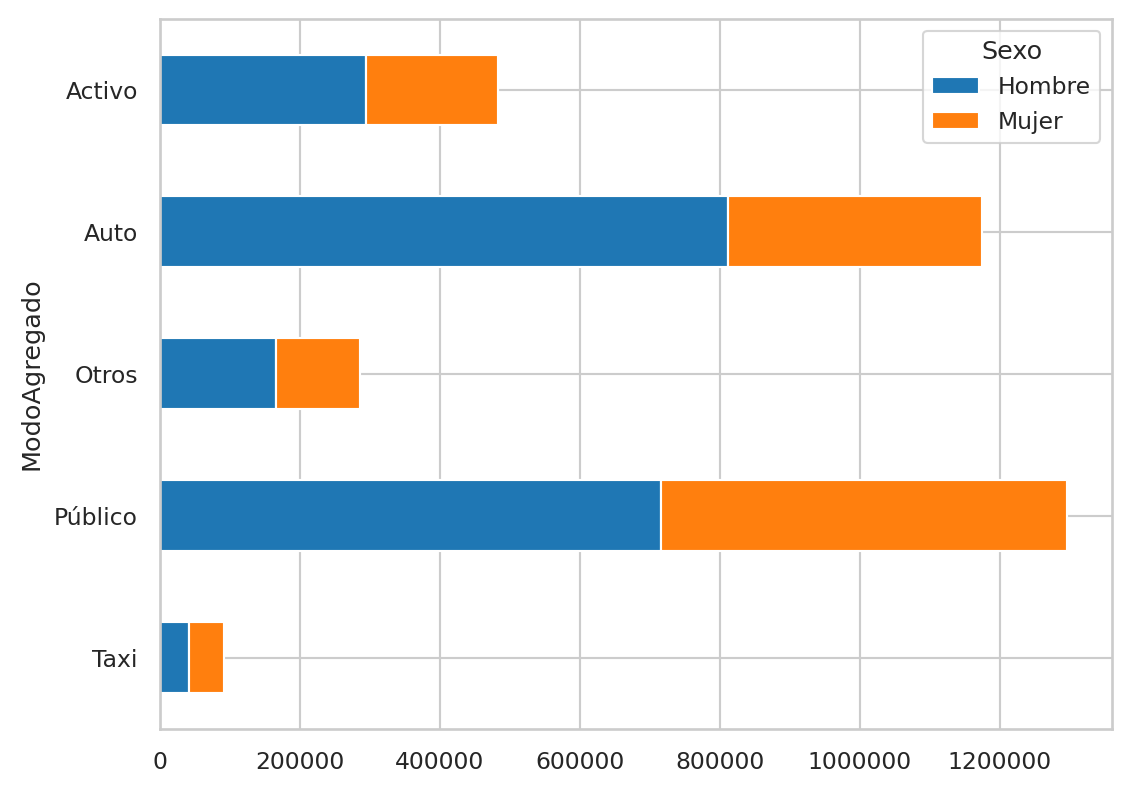

In [45]:
modo_x_actividad = grid_destinos.groupby(["actividad", "ModoAgregado", "Sexo"])["Peso"].sum().unstack(
    fill_value=0
).astype(int)

modo_x_actividad.loc["Recurrentes"].sort_index(ascending=False).plot(
    kind="barh", stacked=True
)

/tmp/ipykernel_8769/3918269223.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


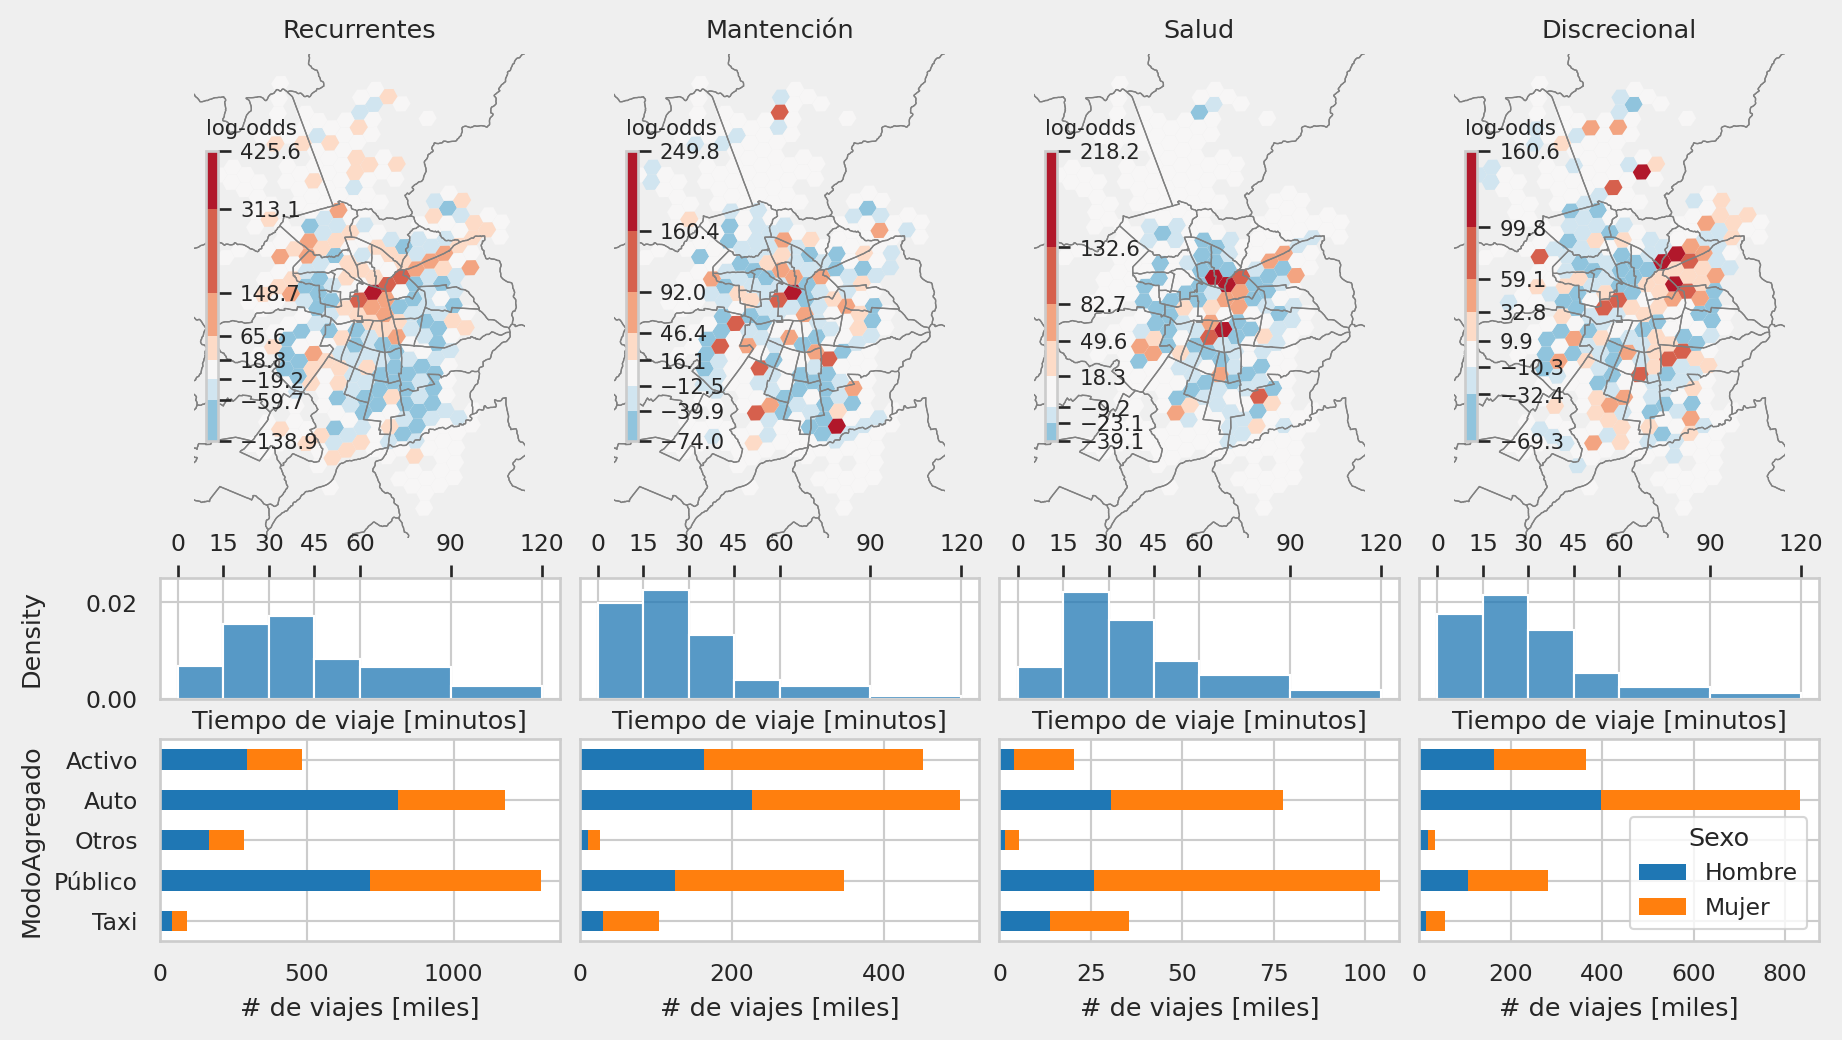

In [46]:
height_ratios = [1.2, 0.3, 0.5]

y_size = sum(height_ratios) * 3
x_size = map_aspect_ratio * len(activity_order) * 3

fig = plt.figure(figsize=(x_size, y_size))
fig.set_facecolor('#efefef')

gs = gridspec.GridSpec(
    len(height_ratios),
    len(activity_order),
    figure=fig,
    hspace=0.15,
    wspace=0.05,
    height_ratios=height_ratios,
)

for i, col in enumerate(activity_order):
    ax_map = fig.add_subplot(gs[0,i])
    ax_hist = fig.add_subplot(gs[1,i])

    choropleth_map(ax_map, hex_grid.geodf.join(grid_actividades, on='h3_cell_id'),col, k=7, binning='fisher_jenks', edgecolor='none', cbar_args=dict(
        label="log-odds",
        height="60%",
        width="4%",
        orientation="vertical",
        location="center left",
        label_size="small",
        bbox_to_anchor=(0.0, 0.0, 0.9, 1.0),
    ))
    ax_map.set_title(col)
    ax_map.set_aspect('equal')
    ax_map.set_axis_off()

    _xlim = ax_map.get_xlim()
    _ylim = ax_map.get_ylim()

    # geopandas cambia los límites
    comunas.plot(ax=ax_map, edgecolor='grey', facecolor='none', linewidth=0.5)

    ax_map.set_xlim(_xlim)
    ax_map.set_ylim(_ylim)

    sns.histplot(data=grid_destinos[grid_destinos['actividad'] == col], x='TiempoViaje', weights='Peso', stat='density', bins=[0, 15, 30, 45, 60, 90, 120], ax=ax_hist)
    ax_hist.set_ylim([0, 0.025])

    ax_hist.set_xticks([0, 15, 30, 45, 60, 90, 120])
    ax_hist.set_xlabel('Tiempo de viaje [minutos]')
    ax_hist.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

    if i > 0:
        ax_hist.set_yticklabels([])
        ax_hist.set_ylabel('')

    #break

    ax_modes = fig.add_subplot(gs[2,i])

    modo_x_actividad.loc[col].sort_index(ascending=False).div(1000).plot(
        kind="barh", stacked=True, ax=ax_modes, legend=(i == (len(activity_order) - 1)), edgecolor='none'
    )

    if i > 0:
        ax_modes.set_ylabel('')
        ax_modes.set_yticklabels([])

    ax_modes.set_xlabel('# de viajes [miles]')
    
fig.tight_layout()
fig.align_ylabels()